# Attribute

**Original Work**: *Maziar Raissi, Paris Perdikaris, and George Em Karniadakis*

**Github Repo** : https://github.com/maziarraissi/PINNs

**Link:** https://github.com/maziarraissi/PINNs/tree/master/appendix/continuous_time_identification%20(Burgers)

@article{raissi2017physicsI,
  title={Physics Informed Deep Learning (Part I): Data-driven Solutions of Nonlinear Partial Differential Equations},
  author={Raissi, Maziar and Perdikaris, Paris and Karniadakis, George Em},
  journal={arXiv preprint arXiv:1711.10561},
  year={2017}
}

@article{raissi2017physicsII,
  title={Physics Informed Deep Learning (Part II): Data-driven Discovery of Nonlinear Partial Differential Equations},
  author={Raissi, Maziar and Perdikaris, Paris and Karniadakis, George Em},
  journal={arXiv preprint arXiv:1711.10566},
  year={2017}
}

## Libraries and Dependencies

In [1]:
import sys

import torch
from collections import OrderedDict

import numpy as np
import matplotlib.pyplot as plt
import scipy.io
from scipy.interpolate import griddata
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec
import warnings

warnings.filterwarnings('ignore')

np.random.seed(1234)

In [2]:
# CUDA support 
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

## Physics-informed Neural Networks

In [3]:
# the deep neural network
class DNN(torch.nn.Module):
    def __init__(self, layers):
        super(DNN, self).__init__()
        
        # parameters
        self.depth = len(layers) - 1
        
        # set up layer order dict
        self.activation = torch.nn.Tanh
        
        layer_list = list()
        for i in range(self.depth - 1): 
            layer_list.append(
                ('layer_%d' % i, torch.nn.Linear(layers[i], layers[i+1]))
            )
            layer_list.append(('activation_%d' % i, self.activation()))
            
        layer_list.append(
            ('layer_%d' % (self.depth - 1), torch.nn.Linear(layers[-2], layers[-1]))
        )
        layerDict = OrderedDict(layer_list)
        print(f'layer Dict:{layerDict}')
        
        # deploy layers
        self.layers = torch.nn.Sequential(layerDict)
        
    def forward(self, x):
        out = self.layers(x)
        return out

In [4]:
# the physics-guided neural network
class PhysicsInformedNN():
    def __init__(self, X, u, layers, lb, ub):
        
        # boundary conditions
        self.lb = torch.tensor(lb).float().to(device)
        self.ub = torch.tensor(ub).float().to(device)
        
        # data
        self.x = torch.tensor(X[:, 0:1], requires_grad=True).float().to(device)
        self.t = torch.tensor(X[:, 1:2], requires_grad=True).float().to(device)
        self.u = torch.tensor(u).float().to(device)
        
        # settings
        # add unknown parameters
        self.lambda1 = torch.tensor([0.0], requires_grad=True).to(device)
        self.lambda2 = torch.tensor([-6.0], requires_grad=True).to(device)
        
        # 학습가능한 매개변수로 추가
        self.lambda1 = torch.nn.Parameter(self.lambda1)
        self.lambda2 = torch.nn.Parameter(self.lambda2)
        
        # deep neural networks
        self.dnn = DNN(layers).to(device)
        self.dnn.register_parameter('lambda1', self.lambda1)
        self.dnn.register_parameter('lambda2', self.lambda2)
        
        # optimizers: using the same settings
        self.optimizer = torch.optim.LBFGS(
            self.dnn.parameters(), 
            lr=1.0, 
            max_iter=50000, 
            max_eval=50000, 
            history_size=50,
            tolerance_grad=1e-5, 
            tolerance_change=1.0 * np.finfo(float).eps,
            line_search_fn="strong_wolfe"       # can be "strong_wolfe"
        )
        
        # for optimizing lambda1, labmda2
        self.optimizer_Adam = torch.optim.Adam(self.dnn.parameters())
        self.iter = 0
        
    def net_u(self, x, t):  
        u = self.dnn(torch.cat([x, t], dim=1))
        return u
    
    def net_f(self, x, t):
        """ The pytorch autograd version of calculating residual """
        lambda1 = self.lambda1
        # for lambda2 > 0        
        lambda2 = torch.exp(self.lambda2)
        u = self.net_u(x, t)
        
        u_t = torch.autograd.grad(
            u, t, 
            grad_outputs=torch.ones_like(u),
            retain_graph=True,
            create_graph=True
        )[0]
        u_x = torch.autograd.grad(
            u, x, 
            grad_outputs=torch.ones_like(u),
            retain_graph=True,
            create_graph=True
        )[0]
        u_xx = torch.autograd.grad(
            u_x, x, 
            grad_outputs=torch.ones_like(u_x),
            retain_graph=True,
            create_graph=True
        )[0]
        
        f = u_t + lambda1 * u * u_x - lambda2 * u_xx
        return f
    
    def loss_func(self):
        u_pred = self.net_u(self.x, self.t)
        f_pred = self.net_f(self.x, self.t)
        loss = torch.mean((self.u - u_pred) ** 2) + torch.mean(f_pred ** 2)
        self.optimizer.zero_grad()
        loss.backward()
        
        self.iter += 1
        if self.iter % 100 == 0:
            print(
                'Loss: %e, l1: %.5f, l2: %.5f' % 
                (
                    loss.item(), 
                    self.lambda1.item(), 
                    torch.exp(self.lambda2.detach()).item()
                )
            )
        return loss
    
    def train(self, nIter):
        self.dnn.train()
        for epoch in range(nIter):
            u_pred = self.net_u(self.x, self.t)
            f_pred = self.net_f(self.x, self.t)
            loss = torch.mean((self.u - u_pred) ** 2) + torch.mean(f_pred ** 2)
            
            # Backward and optimize
            self.optimizer_Adam.zero_grad()
            loss.backward()
            self.optimizer_Adam.step()
            
            if epoch % 500 == 0:
                print(
                    'It: %d, Loss: %.3e, Lambda_1: %.3f, Lambda_2: %.6f' % 
                    (
                        epoch, 
                        loss.item(), 
                        self.lambda1.item(), 
                        torch.exp(self.lambda2).item()
                    )
                )
                
        # Backward and optimize
        self.optimizer.step(self.loss_func)
    
    def predict(self, X):
        x = torch.tensor(X[:, 0:1], requires_grad=True).float().to(device)
        t = torch.tensor(X[:, 1:2], requires_grad=True).float().to(device)

        self.dnn.eval()
        u = self.net_u(x, t)
        f = self.net_f(x, t)
        u = u.detach().cpu().numpy()
        f = f.detach().cpu().numpy()
        return u, f

## Configurations

In [5]:
nu = 0.01/np.pi

N_u = 2000
layers = [2, 20, 20, 20, 20, 20, 20, 20, 20, 1]

data = scipy.io.loadmat('data/burgers_shock.mat')

t = data['t'].flatten()[:,None]
x = data['x'].flatten()[:,None]
Exact = np.real(data['usol']).T

X, T = np.meshgrid(x,t)

X_star = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))
u_star = Exact.flatten()[:,None]              

# Domain bounds
lb = X_star.min(0)
ub = X_star.max(0) 

## Training on Non-noisy Data

In [6]:
%%time

noise = 0.0            

# create training set
idx = np.random.choice(X_star.shape[0], N_u, replace=False)
X_u_train = X_star[idx,:]
u_train = u_star[idx,:]

# training
model = PhysicsInformedNN(X_u_train, u_train, layers, lb, ub)
# Iteration 없이 초기만 확인
model.train(0)

layer Dict:OrderedDict([('layer_0', Linear(in_features=2, out_features=20, bias=True)), ('activation_0', Tanh()), ('layer_1', Linear(in_features=20, out_features=20, bias=True)), ('activation_1', Tanh()), ('layer_2', Linear(in_features=20, out_features=20, bias=True)), ('activation_2', Tanh()), ('layer_3', Linear(in_features=20, out_features=20, bias=True)), ('activation_3', Tanh()), ('layer_4', Linear(in_features=20, out_features=20, bias=True)), ('activation_4', Tanh()), ('layer_5', Linear(in_features=20, out_features=20, bias=True)), ('activation_5', Tanh()), ('layer_6', Linear(in_features=20, out_features=20, bias=True)), ('activation_6', Tanh()), ('layer_7', Linear(in_features=20, out_features=20, bias=True)), ('activation_7', Tanh()), ('layer_8', Linear(in_features=20, out_features=1, bias=True))])
Loss: 2.732923e-02, l1: 0.21619, l2: 0.00245
Loss: 1.735678e-02, l1: 0.38175, l2: 0.00262
Loss: 1.075624e-02, l1: 0.58136, l2: 0.00413
Loss: 5.021943e-03, l1: 0.74621, l2: 0.00527
Loss

In [7]:
# evaluations
u_pred, f_pred = model.predict(X_star)

error_u = np.linalg.norm(u_star-u_pred,2)/np.linalg.norm(u_star,2)

U_pred = griddata(X_star, u_pred.flatten(), (X, T), method='cubic')

lambda1_value = model.lambda1.detach().cpu().numpy()
lambda2_value = model.lambda2.detach().cpu().numpy()
lambda2_value = np.exp(lambda2_value)

error_lambda1 = np.abs(lambda1_value - 1.0) * 100
error_lambda2 = np.abs(lambda2_value - nu) / nu * 100

print('Error u: %e' % (error_u))    
print('Error l1: %.5f%%' % (error_lambda1))                             
print('Error l2: %.5f%%' % (error_lambda2))  
print(f'labmda1 : {lambda1_value}')
print(f'labmda2 : {lambda2_value}')

Error u: 3.778623e-03
Error l1: 0.13786%
Error l2: 0.41345%
labmda1 : [0.9986214]
labmda2 : [0.00316994]


## Training on Noisy Data

In [8]:
noise = 0.01    

# create training set for Normal distribution
u_train = u_train + noise * np.std(u_train)*np.random.randn(u_train.shape[0], u_train.shape[1])

# training
model = PhysicsInformedNN(X_u_train, u_train, layers, lb, ub)
model.train(10000)            

layer Dict:OrderedDict([('layer_0', Linear(in_features=2, out_features=20, bias=True)), ('activation_0', Tanh()), ('layer_1', Linear(in_features=20, out_features=20, bias=True)), ('activation_1', Tanh()), ('layer_2', Linear(in_features=20, out_features=20, bias=True)), ('activation_2', Tanh()), ('layer_3', Linear(in_features=20, out_features=20, bias=True)), ('activation_3', Tanh()), ('layer_4', Linear(in_features=20, out_features=20, bias=True)), ('activation_4', Tanh()), ('layer_5', Linear(in_features=20, out_features=20, bias=True)), ('activation_5', Tanh()), ('layer_6', Linear(in_features=20, out_features=20, bias=True)), ('activation_6', Tanh()), ('layer_7', Linear(in_features=20, out_features=20, bias=True)), ('activation_7', Tanh()), ('layer_8', Linear(in_features=20, out_features=1, bias=True))])
It: 0, Loss: 3.983e-01, Lambda_1: 0.001, Lambda_2: 0.002479
It: 500, Loss: 2.274e-02, Lambda_1: 0.170, Lambda_2: 0.002158
It: 1000, Loss: 1.117e-02, Lambda_1: 0.417, Lambda_2: 0.002534

## Visualizations

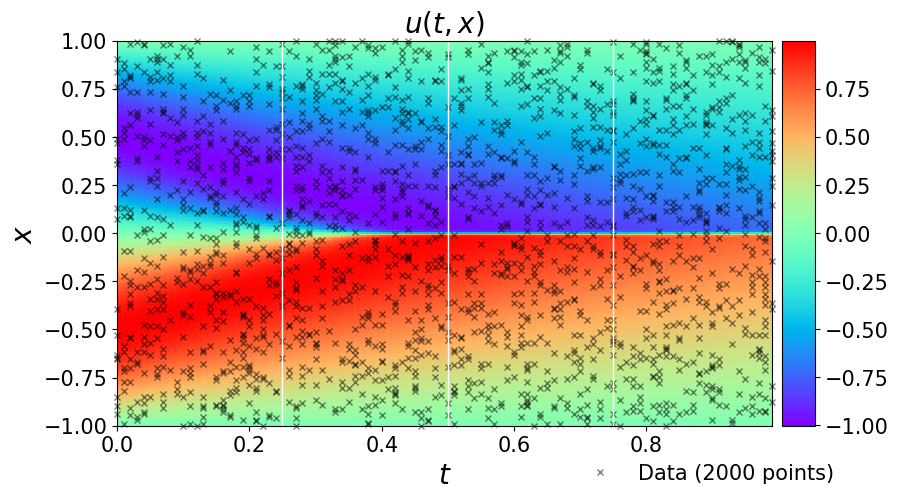

In [9]:

""" The aesthetic setting has changed. """

####### Row 0: u(t,x) ##################    

fig = plt.figure(figsize=(9, 5))
ax = fig.add_subplot(111)

h = ax.imshow(U_pred.T, interpolation='nearest', cmap='rainbow', 
              extent=[t.min(), t.max(), x.min(), x.max()], 
              origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.10)
cbar = fig.colorbar(h, cax=cax)
cbar.ax.tick_params(labelsize=15) 

ax.plot(
    X_u_train[:,1], 
    X_u_train[:,0], 
    'kx', label = 'Data (%d points)' % (u_train.shape[0]), 
    markersize = 4,  # marker size doubled
    clip_on = False,
    alpha=.5
)

line = np.linspace(x.min(), x.max(), 2)[:,None]
ax.plot(t[25]*np.ones((2,1)), line, 'w-', linewidth = 1)
ax.plot(t[50]*np.ones((2,1)), line, 'w-', linewidth = 1)
ax.plot(t[75]*np.ones((2,1)), line, 'w-', linewidth = 1)

ax.set_xlabel('$t$', size=20)
ax.set_ylabel('$x$', size=20)
ax.legend(
    loc='upper center', 
    bbox_to_anchor=(0.9, -0.05), 
    ncol=5, 
    frameon=False, 
    prop={'size': 15}
)
ax.set_title('$u(t,x)$', fontsize = 20) # font size doubled
ax.tick_params(labelsize=15)

plt.show()

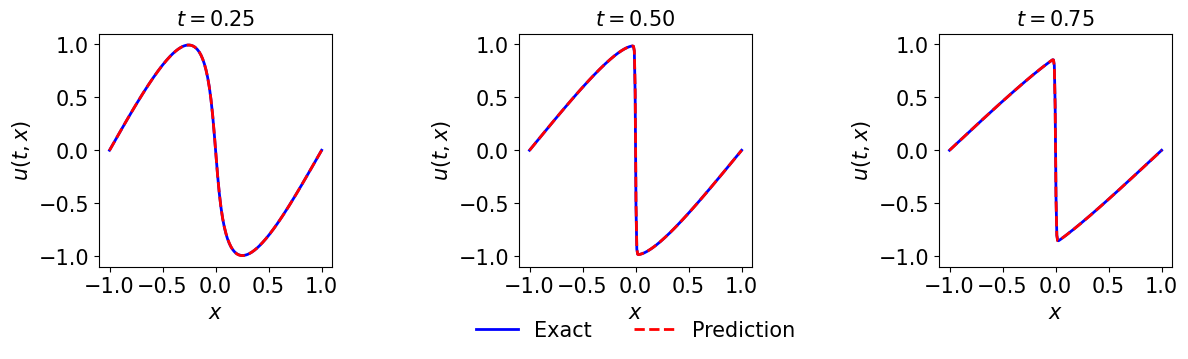

In [10]:
####### Row 1: u(t,x) slices ################## 

""" The aesthetic setting has changed. """

fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111)

gs1 = gridspec.GridSpec(1, 3)
gs1.update(top=1-1.0/3.0-0.1, bottom=1.0-2.0/3.0, left=0.1, right=0.9, wspace=0.5)

ax = plt.subplot(gs1[0, 0])
ax.plot(x,Exact[25,:], 'b-', linewidth = 2, label = 'Exact')       
ax.plot(x,U_pred[25,:], 'r--', linewidth = 2, label = 'Prediction')
ax.set_xlabel('$x$')
ax.set_ylabel('$u(t,x)$')    
ax.set_title('$t = 0.25$', fontsize = 15)
ax.axis('square')
ax.set_xlim([-1.1,1.1])
ax.set_ylim([-1.1,1.1])

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(15)

ax = plt.subplot(gs1[0, 1])
ax.plot(x,Exact[50,:], 'b-', linewidth = 2, label = 'Exact')       
ax.plot(x,U_pred[50,:], 'r--', linewidth = 2, label = 'Prediction')
ax.set_xlabel('$x$')
ax.set_ylabel('$u(t,x)$')
ax.axis('square')
ax.set_xlim([-1.1,1.1])
ax.set_ylim([-1.1,1.1])
ax.set_title('$t = 0.50$', fontsize = 15)
ax.legend(
    loc='upper center', 
    bbox_to_anchor=(0.5, -0.15), 
    ncol=5, 
    frameon=False, 
    prop={'size': 15}
)

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(15)

ax = plt.subplot(gs1[0, 2])
ax.plot(x,Exact[75,:], 'b-', linewidth = 2, label = 'Exact')       
ax.plot(x,U_pred[75,:], 'r--', linewidth = 2, label = 'Prediction')
ax.set_xlabel('$x$')
ax.set_ylabel('$u(t,x)$')
ax.axis('square')
ax.set_xlim([-1.1,1.1])
ax.set_ylim([-1.1,1.1])    
ax.set_title('$t = 0.75$', fontsize = 15)

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(15)

plt.show()

In [11]:
# evaluations
u_pred, f_pred = model.predict(X_star)

lambda1_noisy = model.lambda1.detach().cpu().numpy()
lambda2_noisy = model.lambda2.detach().cpu().numpy()
lambda2_noisy = np.exp(lambda2_noisy)

error_lambda1_noisy = np.abs(lambda1_noisy - 1.0) * 100
error_lambda2_noisy = np.abs(lambda2_noisy - nu) / nu * 100

print('Error u: %e' % (error_u))    
print('Error l1: %.5f%%' % (error_lambda1_noisy))                             
print('Error l2: %.5f%%' % (error_lambda2_noisy))    

Error u: 3.778623e-03
Error l1: 0.18911%
Error l2: 0.34474%


In [12]:
print(f'========Non-noise=========')
print(f'lambda1 : {lambda1_value}')
print(f'lambda2 : {lambda2_value}')

print(f'========Noise=========')
print(f'lambda1 : {lambda1_noisy}')
print(f'lambda2 : {lambda2_noisy}')

========Non-noise=========
lambda1 : [0.9986214]
lambda2 : [0.00316994]
========Noise=========
lambda1 : [0.99810886]
lambda2 : [0.00319407]
